In [ ]:
class StopExecution(Exception):
    def _render_traceback_(self):
        return []

In [ ]:
import os
import sys

if os.path.basename(os.getcwd()) == "testing":
    os.chdir(os.path.dirname(os.getcwd()))
    sys.path.append(os.getcwd())

import unittest
from lossless.util.distribution import (
    weak_colorar_rate,
    discretized_logistic_logp,
    get_mu_and_scale_linear_color
)
import lossless.util.color_transform as color_transform
import torch
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
# plt.rcParams["figure.dpi"] = 150

def unget_scale(scale: torch.Tensor) -> torch.Tensor:
    """Helper function to get log_scale from scale

    Args:
        - scale (torch.Tensor): Tensor of shape N x C x H x W
    """
    logscale = torch.log(scale) * -2
    logscale = torch.clamp(logscale, min=-10.0, max=13.8155)
    return logscale

_ = (
# def inflate_mu_and_scale_linear_color(
#     mu: torch.Tensor, log_scale: torch.Tensor, x: torch.Tensor
# ) -> torch.Tensor:
#     """Helper function to get params from mu and scale

#     Args:
#         - mu (torch.Tensor): Tensor of shape N x 3 x H x W
#         - log_scale (torch.Tensor): Tensor of shape N x 3 x H x W
#         - x (torch.Tensor): Tensor of shape N x 3 x H x W
#     """
#     pass


# class TestWeakColorarRate(unittest.TestCase):
#     def simple_case(self):
#         channel_ranges = color_transform.RGBBitdepths()
#         x = torch.tensor([[[[0.40802]], [[0.24332]], [[0.63202]]]])
#         print(x.shape)
#         mu = x + 0.1
#         logscale = torch.tensor([[[[0.0]], [[0.0]], [[0.0]]]])
#         params = inflate_mu_and_scale_linear_color(mu, logscale, x)

# TestWeakColorarRate().simple_case()
)

class MonochromeBitdepths(color_transform.ColorBitdepths):
    def __init__(self) -> None:
        self.bitdepths = [8]
        self.scaling_factors = [255]
        self.bins = [256]
        self.ranges_int = [[0, 255]]


DEFAULT_LOGSCALE = 13.4
DEFAULT_SHIFT = 0.0
DEFAULT_IMG_VALUE = 0.00802


def plot_logp(shifts: np.ndarray | None, logscales: np.ndarray | None):
    channel_ranges = MonochromeBitdepths()
    x = torch.ones((1, 1, 1, 1)) * DEFAULT_IMG_VALUE

    # shifts is a linspace
    logps = []

    if shifts is not None:
        for shift_value in shifts:
            shift = torch.tensor(shift_value)
            mu = x + shift
            log_scale = torch.clamp(
                torch.tensor(DEFAULT_LOGSCALE), min=-10.0, max=13.8155
            )
            scale = torch.exp(-0.5 * log_scale)
            logp = discretized_logistic_logp(mu, scale, x, channel_ranges)
            logps.append(-logp.item())
        plt.plot(shifts, logps)
        plt.xlabel("Shift")
        plt.ylabel("Negative Log Probability")
        plt.title("Negative Log Probability vs Shift")
        plt.show()
    if logscales is not None:
        logps = []
        for logscale_value in logscales:
            shift = torch.tensor(DEFAULT_SHIFT)
            mu = x + shift
            log_scale = torch.clamp(
                torch.tensor(logscale_value), min=-10.0, max=13.8155
            )
            scale = torch.exp(-0.5 * log_scale)
            logp = discretized_logistic_logp(mu, scale, x, channel_ranges)
            logps.append(-logp.item())
        plt.plot(logscales, logps)
        plt.xlabel("Log Scale")
        plt.ylabel("Negative Log Probability")
        plt.title("Negative Log Probability vs Log Scale")
        plt.show()


def logp_image(shifts: np.ndarray, logscales: np.ndarray):
    channel_ranges = MonochromeBitdepths()
    x = torch.ones((1, 1, 1, 1)) * DEFAULT_IMG_VALUE

    logp_matrix = np.zeros((len(logscales), len(shifts)))

    for j, shift_value in enumerate(shifts):
        for i, logscale_value in enumerate(logscales):
            shift = torch.tensor(shift_value)
            mu = x + shift
            log_scale = torch.clamp(
                torch.tensor(logscale_value), min=-10.0, max=13.8155
            )
            scale = torch.exp(-0.5 * log_scale)
            logp = discretized_logistic_logp(mu, scale, x, channel_ranges)
            logp_matrix[i, j] = -logp.item()

    plt.imshow(
        logp_matrix,
        extent=(shifts[0], shifts[-1], logscales[0], logscales[-1]),
        aspect="auto",
        origin="lower",
    )
    plt.colorbar(label="Negative Log Probability")
    plt.xlabel("Shift")
    plt.ylabel("Log Scale")
    plt.title("Negative Log Probability Heatmap")
    plt.show()


logp_image(np.linspace(-0.5, 0.5, 100), np.linspace(-10.0, 13.8154, 100))

In [ ]:
raw_out = torch.tensor(np.load("./testing/data/encoded_raw_out.npy"))
image = torch.tensor(np.load("./testing/data/original_image.npy"))

mu, scale = get_mu_and_scale_linear_color(
    raw_out, image
)

# for channel in range(3):
#     channel_ranges = MonochromeBitdepths()
#     logps = - discretized_logistic_logp(
#         mu[:, channel : channel + 1],
#         scale[:, channel : channel + 1],
#         image[:, channel : channel + 1],
#         channel_ranges,
#     )
#     print((logps >= 10).sum())
#     print(logps.mean())
#     plt.figure()
#     plt.title(f"Channel {channel} - logps values")
#     plt.imshow(logps[0].permute(1, 2, 0).numpy(), vmin=0, vmax=16)
#     plt.colorbar(label="logp value")
#     plt.xlabel("Width")
#     plt.ylabel("Height")
#     plt.show()

In [ ]:
for channel in range(3):
    channel_ranges = MonochromeBitdepths()
    mu_slice = mu[:, channel : channel + 1]
    image_slice = image[:, channel : channel + 1]
    diff = abs(mu_slice - image_slice)
    print(diff.min(), diff.mean(), diff.max())
    plt.figure()
    plt.title(f"Channel {channel} - mu values")
    plt.imshow(diff[0].permute(1, 2, 0).numpy()*255)
    plt.colorbar(label="mu value")
    plt.xlabel("Width")
    plt.ylabel("Height")
    plt.show()

In [ ]:
import torchac
import torch
from lossless.util.distribution import compute_logistic_cdfs
from typing import Literal
from lossless.util.color_transform import ColorBitdepths

POSSIBLE_DISTRIBUTIONS = Literal["logistic", "laplace"]


def get_bits_per_pixel(w, h, c, encoded_bytes):
    num_pixels = w * h * c
    num_bits = 0
    for bytes_channel in encoded_bytes:
        num_bits += len(bytes_channel) * 8
    return num_bits / num_pixels


def _laplace_cdf(
    x: torch.Tensor, expectation: torch.Tensor, scale: torch.Tensor
) -> torch.Tensor:
    """Compute the laplace cumulative evaluated in x. All parameters
    must have the same dimension.
    Re-implemented here coz it is faster than calling the Laplace distribution
    from torch.distributions.

    Args:
        x (Tensor): Where the cumulative if evaluated.
        expectation (Tensor): Expectation.
        scale (Tensor): Scale

    Returns:
        Tensor: CDF(x, mu, scale)
    """
    shifted_x = x - expectation
    return 0.5 - 0.5 * (shifted_x).sign() * torch.expm1(
        -(shifted_x).abs() / scale
    )


def _logistic_cdf(
    x: torch.Tensor, mu: torch.Tensor, s: torch.Tensor
) -> torch.Tensor:
    """Compute the logistic cumulative evaluated in x. All parameters
    must have the same dimension.
    Re-implemented here coz it is faster than calling the Logistic distribution
    from torch.distributions.

    Args:
        x (Tensor): Where the cumulative if evaluated.
        mu (Tensor): Expectation.
        s (Tensor): Scale

    Returns:
        Tensor: CDF(x, mu, scale)
    """
    z = (x - mu) / s
    return torch.sigmoid(z)


def calculate_probability_distribution(
    mu,
    s,
    color_bitdepths: ColorBitdepths,
    distribution: POSSIBLE_DISTRIBUTIONS,
    channel_idx: int,
):
    """Calculate Logistic probability distribution for arithmetic coding.
    Works for any shape of mu and s, adds one dimension at the end for the probability axis.
    """
    # Create the base tensor of quantized values
    new_tensor = torch.linspace(
        color_bitdepths.ranges_int[channel_idx][0]
        / color_bitdepths.scaling_factors[channel_idx],
        color_bitdepths.ranges_int[channel_idx][1]
        / color_bitdepths.scaling_factors[channel_idx],
        steps=color_bitdepths.bins[channel_idx],
        device=mu.device,
    )
    new_shape = (
        *mu.shape,
        color_bitdepths.bins[channel_idx],
    )  # add one dimension at the end
    new_tensor = new_tensor.view(
        *([1] * mu.ndim), color_bitdepths.bins[channel_idx]
    ).expand(*new_shape)

    # Compute boundaries for each bin
    x_minus = new_tensor - 0.5 / color_bitdepths.bins[channel_idx]
    x_plus = new_tensor + 0.5 / color_bitdepths.bins[channel_idx]

    # Expand mu and s with one trailing dimension
    mu_expanded = mu.unsqueeze(-1)
    s_expanded = s.unsqueeze(-1)

    # Logistic CDF difference between bin edges (use the logistic cdf function)
    if distribution == "laplace":
        cdf_minus = _laplace_cdf(x_minus, mu_expanded, s_expanded)
        cdf_plus = _laplace_cdf(x_plus, mu_expanded, s_expanded)
    elif distribution == "logistic":
        cdf_minus = _logistic_cdf(x_minus, mu_expanded, s_expanded)
        cdf_plus = _logistic_cdf(x_plus, mu_expanded, s_expanded)

    prob_t = cdf_plus - cdf_minus
    prob_t = torch.clamp_min(prob_t, 2 ** (-16))
    prob_t = prob_t / prob_t.sum(dim=-1, keepdim=True)

    return prob_t


def dist_to_cfd(prob_dist: torch.Tensor) -> torch.Tensor:
    # we go from probability table in the last dimension [..., num_symbols] to CDF table in the last dimension [..., num_symbols + 1]
    cdf = torch.zeros(
        *prob_dist.shape[:-1],
        prob_dist.shape[-1] + 1,
        device=prob_dist.device,
        dtype=torch.float32,
    )
    cdf[..., 1:] = prob_dist.cumsum(dim=-1)
    cdf[..., -1] = 0  # ensure last value is exactly 0
    cdf = torch.round(cdf * float(1 << 16)).to(torch.int32)
    cdf[..., -1] = 0  # ensure last value is exactly 2^16
    return cdf.to(torch.int16)


def encode(
    x: torch.Tensor,
    mu: torch.Tensor,
    scale: torch.Tensor,
    color_bitdepths: ColorBitdepths,
    distribution: POSSIBLE_DISTRIBUTIONS = "logistic",
):
    # this undoes normalization
    x_reshape = torch.floor(x * 255).to(torch.int16).cpu()

    byte_strings = []
    for i in range(3):
        symbols = x_reshape[:, i : i + 1, ...]
        # print(
        #     f"Channel {i}: symbols shape {symbols.shape}, min {symbols.min()}, max {symbols.max()}"
        # )
        cur_cdfs = dist_to_cfd(
            calculate_probability_distribution(
                mu[:, i : i + 1, ...],
                scale[:, i : i + 1, ...],
                color_bitdepths=color_bitdepths,
                distribution=distribution,
                channel_idx=i,
            )
        ).cpu()
        byte_strings.append(
            torchac.encode_int16_normalized_cdf(cur_cdfs, symbols)
        )
    return byte_strings


def decode(
    byte_strings: list,
    mu: torch.Tensor,
    scale: torch.Tensor,
    color_bitdepths: ColorBitdepths,
    distribution: POSSIBLE_DISTRIBUTIONS = "logistic",
):
    assert len(byte_strings) == 3

    _, _, h, w = mu.size()
    x_rec = torch.zeros(1, 3, h, w)

    # Channel 0 (Red)
    cur_cdfs_r = dist_to_cfd(
        calculate_probability_distribution(
            mu[:, :1, ...],
            scale[:, :1, ...],
            color_bitdepths=color_bitdepths,
            distribution=distribution,
            channel_idx=0,
        )
    ).cpu()
    symbols_r = torchac.decode_int16_normalized_cdf(cur_cdfs_r, byte_strings[0])
    print(
        f"Decoded R: shape {symbols_r.shape}, min {symbols_r.min()}, max {symbols_r.max()}"
    )
    x_r = symbols_r.reshape(1, 1, h, w).float() / 255
    x_rec[:, 0:1, ...] = x_r  # FIX: was using 3*i (which is 0), should be 0:1

    # Channel 1 (Green)
    cur_cdfs_g = dist_to_cfd(
        calculate_probability_distribution(
            mu[:, 1:2, ...],
            scale[:, 1:2, ...],
            color_bitdepths=color_bitdepths,
            distribution=distribution,
            channel_idx=1,
        )
    ).cpu()
    symbols_g = torchac.decode_int16_normalized_cdf(cur_cdfs_g, byte_strings[1])
    print(
        f"Decoded G: shape {symbols_g.shape}, min {symbols_g.min()}, max {symbols_g.max()}"
    )
    x_g = symbols_g.reshape(1, 1, h, w).float() / 255
    x_rec[:, 1:2, ...] = x_g  # FIX: was using 3*i+1 (which is 1), should be 1:2

    # Channel 2 (Blue)
    cur_cdfs_b = dist_to_cfd(
        calculate_probability_distribution(
            mu[:, 2:3, ...],
            scale[:, 2:3, ...],
            color_bitdepths=color_bitdepths,
            distribution=distribution,
            channel_idx=2,
        )
    ).cpu()
    symbols_b = torchac.decode_int16_normalized_cdf(cur_cdfs_b, byte_strings[2])
    print(
        f"Decoded B: shape {symbols_b.shape}, min {symbols_b.min()}, max {symbols_b.max()}"
    )
    x_b = symbols_b.reshape(1, 1, h, w).float() / 255
    x_rec[:, 2:3, ...] = x_b  # FIX: was using 3*i+2 (which is 2), should be 2:3

    return x_rec


In [ ]:
# color_bitdepths = color_transform.YCoCgBitdepths()
# prob_logistic = calculate_probability_distribution(mu, scale, color_bitdepths, distribution="logistic", channel_idx=1)[0]
# print(prob_logistic.shape)
# # prob_logistic has shape [3, 512, 768, 256]
# # image has shape [3, 512, 768]
# # index into prob_logistic using image values
# # to get the probabilities of the actual image values
# indices = (image[0]*255).long()
# indices = indices.clamp(0, 255) - color_bitdepths.ranges_int[1][0]
# # indices = torch.zeros_like(indices)
# gathered_probs = prob_logistic.permute(0, 3, 1, 2).gather(1, indices.unsqueeze(1)).squeeze(1)
# print(gathered_probs.shape)  # should be [3, 512, 768]

# for channel in range(3):
#     channel_ranges = MonochromeBitdepths()
#     gp = gathered_probs[channel : channel + 1]
#     print(gp.mean(), gp.shape)
#     plt.figure()
#     plt.title(f"Channel {channel} - probs values")
#     plt.imshow(gp[0].numpy())
#     plt.colorbar(label="probs value")
#     plt.xlabel("Width")
#     plt.ylabel("Height")
#     plt.show()

In [113]:
import torch
import torchac
from lossless.util.distribution import compute_logistic_cdfs
from typing import Literal
from lossless.util.color_transform import ColorBitdepths

POSSIBLE_DISTRIBUTIONS = Literal["logistic", "laplace", "dummy"]


def get_bits_per_pixel(w, h, c, encoded_bytes):
    num_pixels = w * h * c
    num_bits = 0
    for bytes_channel in encoded_bytes:
        num_bits += len(bytes_channel) * 8
    return num_bits / num_pixels


def _laplace_cdf(
    x: torch.Tensor, expectation: torch.Tensor, scale: torch.Tensor
) -> torch.Tensor:
    """Compute the laplace cumulative evaluated in x. All parameters
    must have the same dimension.
    Re-implemented here coz it is faster than calling the Laplace distribution
    from torch.distributions.

    Args:
        x (Tensor): Where the cumulative if evaluated.
        expectation (Tensor): Expectation.
        scale (Tensor): Scale

    Returns:
        Tensor: CDF(x, mu, scale)
    """
    shifted_x = x - expectation
    return 0.5 - 0.5 * (shifted_x).sign() * torch.expm1(
        -(shifted_x).abs() / scale
    )


def _logistic_cdf(
    x: torch.Tensor, mu: torch.Tensor, s: torch.Tensor
) -> torch.Tensor:
    """Compute the logistic cumulative evaluated in x. All parameters
    must have the same dimension.
    Re-implemented here coz it is faster than calling the Logistic distribution
    from torch.distributions.

    Args:
        x (Tensor): Where the cumulative if evaluated.
        mu (Tensor): Expectation.
        s (Tensor): Scale

    Returns:
        Tensor: CDF(x, mu, scale)
    """
    z = (x - mu) / s
    return torch.sigmoid(z)

def calculate_probability_distribution(
    mu,
    s,
    color_bitdepths: ColorBitdepths,
    distribution: POSSIBLE_DISTRIBUTIONS,
    channel_idx: int,
):
    """Calculate Logistic probability distribution for arithmetic coding.
    Works for any shape of mu and s, adds one dimension at the end for the probability axis.
    """
    # Create the base tensor of quantized values
    new_tensor = torch.linspace(
        0.0,
        (
            color_bitdepths.ranges_int[channel_idx][1]
            - color_bitdepths.ranges_int[channel_idx][0]
        )
        / color_bitdepths.scaling_factors[channel_idx],
        steps=color_bitdepths.bins[channel_idx],
        device=mu.device,
    )
    new_shape = (
        *mu.shape,
        color_bitdepths.bins[channel_idx],
    )  # add one dimension at the end
    new_tensor = new_tensor.view(
        *([1] * mu.ndim), color_bitdepths.bins[channel_idx]
    ).expand(*new_shape)

    # Compute boundaries for each bin
    x_minus = new_tensor - 0.5 / color_bitdepths.bins[channel_idx]
    x_plus = new_tensor + 0.5 / color_bitdepths.bins[channel_idx]

    # Expand mu and s with one trailing dimension
    mu_expanded = mu.unsqueeze(-1)
    s_expanded = s.unsqueeze(-1)

    # Logistic CDF difference between bin edges (use the logistic cdf function)
    if distribution == "laplace":
        cdf_minus = _laplace_cdf(x_minus, mu_expanded, s_expanded)
        cdf_plus = _laplace_cdf(x_plus, mu_expanded, s_expanded)
    else:
        cdf_minus = _logistic_cdf(x_minus, mu_expanded, s_expanded)
        cdf_plus = _logistic_cdf(x_plus, mu_expanded, s_expanded)
    prob_t = cdf_plus - cdf_minus
    if distribution == "dummy":
        prob_t = torch.ones_like(cdf_plus)
    prob_t = torch.clamp_min(prob_t, 2 ** (-16))
    prob_t = prob_t / prob_t.sum(dim=-1, keepdim=True)

    assert torch.all(torch.isclose(prob_t.sum(dim=-1), torch.ones_like(mu))), "Probabilities do not sum to 1"
    assert torch.all(prob_t.min() > 0) , "Some probabilities are zero"
    return prob_t


def dist_to_cfd(prob_dist: torch.Tensor) -> torch.Tensor:
    # we go from probability table in the last dimension [..., num_symbols] to CDF table in the last dimension [..., num_symbols + 1]
    cdf = torch.zeros(
        *prob_dist.shape[:-1],
        prob_dist.shape[-1] + 1,
        device=prob_dist.device,
        dtype=torch.float32,
    )
    cdf[..., 1:] = prob_dist.cumsum(dim=-1)
    cdf = torch.round(cdf * float(1 << 16))
    cdf[..., -1] = 0
    return cdf.to(torch.int16)


# def encode(
#     x: torch.Tensor,
#     mu: torch.Tensor,
#     scale: torch.Tensor,
#     color_bitdepths: ColorBitdepths,
#     distribution: POSSIBLE_DISTRIBUTIONS = "logistic",
# ):
#     # this undoes normalization
#     x_reshape = torch.floor(x * 255)

#     byte_strings = []
#     for i in range(3):
#         symbols = x_reshape[:, i : i + 1, ...]
#         print(
#             f"Channel {i}: symbols shape {symbols.shape}, min {symbols.min()}, max {symbols.max()}"
#         )
#         symbols = symbols - color_bitdepths.ranges_int[i][0]
#         mu_print = mu - (color_bitdepths.ranges_int[i][0] / color_bitdepths.scaling_factors[i])

#         cur_cdfs = dist_to_cfd(
#             calculate_probability_distribution(
#                 mu_print[:, i : i + 1, ...],
#                 scale[:, i : i + 1, ...],
#                 color_bitdepths=color_bitdepths,
#                 distribution=distribution,
#                 channel_idx=i,
#             )
#         ).cpu()
#         byte_strings.append(
#             torchac.encode_int16_normalized_cdf(
#                 cur_cdfs, symbols.to(torch.int16).cpu()
#             )
#         )
#     return byte_strings


# def decode(
#     byte_strings: list,
#     mu: torch.Tensor,
#     scale: torch.Tensor,
#     color_bitdepths: ColorBitdepths,
#     distribution: POSSIBLE_DISTRIBUTIONS = "logistic",
# ):
#     assert len(byte_strings) == 3

#     _, _, h, w = mu.size()
#     x_rec = torch.zeros(1, 3, h, w)

#     for i in range(3):

#         # Channel 0 (Red)
#         cur_cdfs = dist_to_cfd(
#             calculate_probability_distribution(
#                 mu[:, i : i + 1, ...]
#                 - (color_bitdepths.ranges_int[i][0]
#                 / color_bitdepths.scaling_factors[i]),
#                 scale[:, i : i + 1, ...],
#                 color_bitdepths=color_bitdepths,
#                 distribution=distribution,
#                 channel_idx=i,
#             )
#         ).cpu()
#         symbols = (
#             torchac.decode_int16_normalized_cdf(cur_cdfs, byte_strings[0])
#             + color_bitdepths.ranges_int[i][0]
#         )
#         print(
#             f"Decoded R: shape {symbols.shape}, min {symbols.min()}, max {symbols.max()}"
#         )
#         x = symbols.reshape(1, 1, h, w).float() / 255
#         x_rec[:, i : i + 1, ...] = (
#             x  # FIX: was using 3*i (which is 0), should be 0:1
#         )

#     return x_rec


In [ ]:
import torch
import constriction
import struct


def encode(
    x: torch.Tensor,
    mu: torch.Tensor,
    scale: torch.Tensor,
    ct: color_transform.ColorBitdepths = color_transform.YCoCgBitdepths(),
    distribution: POSSIBLE_DISTRIBUTIONS = "logistic",
    output_path="./test-workdir/encoder_size_test/coolchic_encoded.binary",
):
    x = x * 255.0
    x_reshape = x.to(torch.int16).cpu()

    B, C, H, W = x.shape
    enc = constriction.stream.stack.AnsCoder()
    bits_theoretical = 0

    with torch.no_grad():
        scale_theoretical_bits = 0
        mu = mu.flatten(2, 3).permute(0, 2, 1)  # B, H*W, C
        scale = scale.flatten(2, 3).permute(0, 2, 1)  # B, H*W, C

        probs_logistic = [
            calculate_probability_distribution(
                mu - ct.ranges_int[ch_ind][0] / ct.scaling_factors[ch_ind],
                scale,
                color_bitdepths=ct,
                distribution=distribution,
                channel_idx=ch_ind,
            )
            for ch_ind in range(C)
        ]

        scale_theoretical_bits = 0
        for wh in range(x.shape[2] * x.shape[3]):
            for c in range(x.shape[1]):
                sym: int = (
                    x_reshape.flatten(2, 3).permute(0, 2, 1)[0, -wh - 1, -c - 1]
                ).int().item() - ct.ranges_int[-c - 1][0]
                prob_t = probs_logistic[-c - 1][0, -wh - 1, -c - 1]
                scale_theoretical_bits += -torch.log2(prob_t[sym]).item()
                model = constriction.stream.model.Categorical(
                    prob_t.detach().cpu().numpy(), perfect=False
                )
                try:
                    enc.encode_reverse(sym, model)
                except Exception as e:

                    print(f"Error encoding symbol {sym} for channel {c}: {e}")
                    raise e
        bits_theoretical += scale_theoretical_bits

    bitstream = enc.get_compressed()
    bitstream.tofile(output_path)
    with open(output_path, "rb") as f:
        original_data = f.read()
    with open(output_path, "wb") as f:
        # Pack two 32-bit integers into binary
        f.write(struct.pack("iii", H, W, C))
        f.write(original_data)

    print(f"Theoretical bits per sub pixel: {bits_theoretical/float(W*H*C)}")
    return probs_logistic


def decode(
    bitstream_path,
    mu: torch.Tensor,
    scale: torch.Tensor,
    ct=color_transform.ColorBitdepths(),
    distribution: POSSIBLE_DISTRIBUTIONS = "logistic",
):
    with open(bitstream_path, "rb") as f:
        header = f.read(12)  # 3 integers * 4 bytes each
        H, W, C = struct.unpack("iii", header)
    bitstream = np.fromfile(bitstream_path, dtype=np.uint32, offset=12)
    dec = constriction.stream.stack.AnsCoder(bitstream)

    x = -torch.ones(1, C, H, W)
    with torch.no_grad():
        mu = mu.flatten(2, 3).permute(0, 2, 1)  # B, H*W, C
        scale = scale.flatten(2, 3).permute(0, 2, 1)  # B, H*W, C

        probs_logistic = [
            calculate_probability_distribution(
                mu - ct.ranges_int[ch_ind][0] / ct.scaling_factors[ch_ind],
                scale,
                color_bitdepths=ct,
                distribution=distribution,
                channel_idx=ch_ind,
            )
            for ch_ind in range(C)
        ]
        for h in range(H):
            for w in range(W):
                for c in range(C):
                    prob = probs_logistic[c][0, h * W + w, c]
                    prob_array = prob.detach().cpu().flatten().numpy()
                    model = constriction.stream.model.Categorical(
                        prob_array, perfect=False
                    )
                    decoded_char = (
                        torch.tensor(dec.decode(model, 1)[0]).float()
                        + ct.ranges_int[c][0]
                    )
                    x[0, c, h, w] = decoded_char

    x = x.cpu() / 255

    return x, probs_logistic

## TESTING ENCODE DECODE LOSSLESSNESS

### Random Image Patch

In [ ]:
# image = torch.ones((1, 3, 32, 32)) * 0.5
# image[:, 0, :16, :16] = 0.1
# image[:, 1, :16, 16:] = 0.3
# image[:, 2, 16:, :16] = 0.9
image = torch.rand((1, 3, 32, 32))
image[0, 1:] = image[0, 1:] * 2 - 1
image = torch.round(image * 255) / 255

mu = torch.rand_like(image)
scale = torch.rand_like(image)

col_b = color_transform.YCoCgBitdepths()
probs_enc = encode(image, mu, scale, ct=col_b, distribution="logistic")
decoded_image, probs_dec = decode("./test-workdir/encoder_size_test/coolchic_encoded.binary", mu, scale, ct=col_b, distribution="logistic")

assert torch.allclose(probs_enc[0], probs_dec[0]), "Probability distributions for channel 0 do not match after encoding and decoding"

# show the original and decoded images side by side. Show the channels separately in a 3 rows and 3 columns layout
fig, axs = plt.subplots(3, 3, figsize=(15, 9))
diff = torch.abs(image - decoded_image)
channel_names = ['Red', 'Green', 'Blue']
for i in range(3):
    axs[i, 0].imshow(image[0, i].cpu(), cmap='gray', vmin=0, vmax=1)
    axs[i, 0].set_title(f'Original {channel_names[i]} Channel min {image[0, i].min().item():.2f} max {image[0, i].max().item():.2f}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(decoded_image[0, i].cpu(), cmap='gray', vmin=0, vmax=1)
    axs[i, 1].set_title(f'Decoded {channel_names[i]} Channel min {decoded_image[0, i].min().item():.2f} max {decoded_image[0, i].max().item():.2f}')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(diff[0, i].cpu(), cmap='gray', vmin=0, vmax=1)
    axs[i, 2].set_title(f'Difference {channel_names[i]} Channel min {diff[0, i].min().item():.2f} max {diff[0, i].max().item():.2f}')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()


print(f"Max difference between original and decoded image: {diff.max().item()}")
# show diff channel by channel
assert torch.allclose(image, decoded_image, atol=1e-6)
print("Encode-decode losslessness test passed!")

### Cool-Chic Predicted Parameters

Theoretical bits per sub pixel: 2.4904356003756525


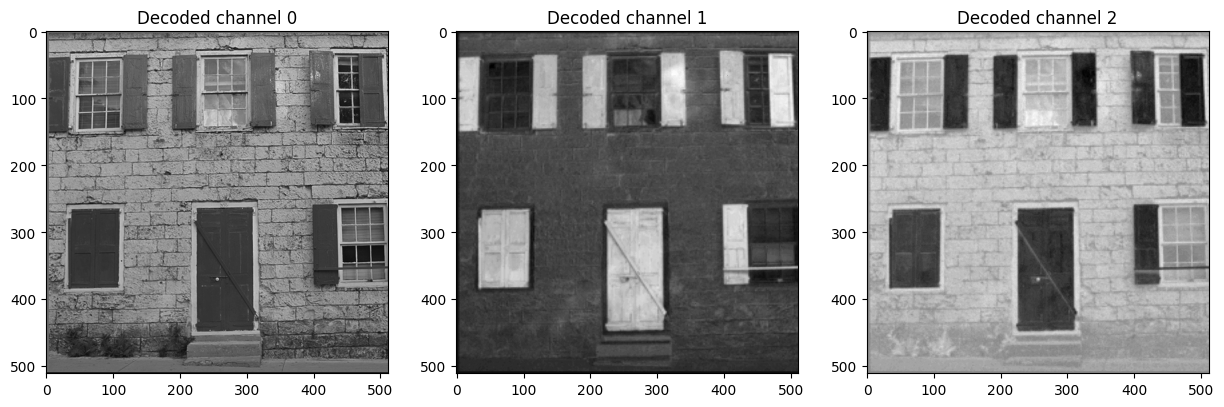

In [ ]:
mu, scale = get_mu_and_scale_linear_color(raw_out, image)

offset = 0
patch_size = 512
patch_image = image[
    :, :, offset : offset + patch_size, offset : offset + patch_size
]
patch_mu = mu[:, :, offset : offset + patch_size, offset : offset + patch_size]
patch_scale = scale[
    :, :, offset : offset + patch_size, offset : offset + patch_size
]

probs_enc = encode(
    patch_image,
    patch_mu,
    patch_scale,
    ct=color_transform.YCoCgBitdepths(),
    distribution="logistic",
    output_path="./test-workdir/encoder_size_test/coolchic_encoded_dummy.binary",
)
dec, probs_dec = decode(
    "./test-workdir/encoder_size_test/coolchic_encoded_dummy.binary",
    patch_mu,
    patch_scale,
    ct=color_transform.YCoCgBitdepths(),
    distribution="logistic",
)

assert torch.allclose(
    patch_image.cpu(), dec.cpu()
), "Decoded image does not match original!"


# rewrite the figure above to subplots with 3 columns and 1 row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for C in range(3):
    axs[C].imshow(dec[0, C, :, :], cmap="gray")
    axs[C].set_title(f"Decoded channel {C}")
plt.show()